<a href="https://colab.research.google.com/github/ShimitaRudra/DataAnalytics-Thesis/blob/main/Drug_reviews_DA_project_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install transformers >> NULL

### Already installed packages

In [ ]:
#!pip install -U spacy

In [ ]:
#!pip install -U spacy[cuda118]

In [ ]:
#!pip install scispacy

In [ ]:
#!pip install -U scispacy

In [ ]:
#!pip install pyarrow

In [ ]:
#!pip install fastparquet

In [ ]:
#!pip install spacy-transformers >> a

In [ ]:
#pip install '/content/drive/MyDrive/Colab Notebooks/Data Analytics Project/en_ner_bc5cdr_md-0.5.1.tar.gz'

### Import statementss

In [9]:
import pandas as pd
import numpy as np
#import spacy
#import spacy_transformers
#import scispacy
from spacy import displacy
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertModel, AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup, AutoConfig

import torch
import torch.nn as nn
import pickle

from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
print("CUDA Version:", torch.version.cuda)

CUDA Version: 11.8


In [5]:
torch.__version__

'2.0.1+cu118'

### Single Scispacy sentences

In [ ]:
print("spaCy version:", spacy.__version__)
#print("scispacy version:", scispacy.__version__)

spaCy version: 3.4.4


In [ ]:
nlp_bcdr = spacy.load("en_ner_bc5cdr_md")

In [ ]:
doc3 = nlp_bcdr("depakene has a very thin coating of acetaminophen, which caused severe heart burn and stomach upset.  The discomfort was so unpleasant that it made me not want to take my meds, so I was not taking them consistently as prescribed.  This caused my mood to fluctuate again.  Even after I switched to the Depakote, my stomach was still uncomfortable for several weeks afterwards.  My appetite decreased and food was very unappetizing.  Certain foods that I normally enjoy, such as chicken or fish, made me feel extremely queasy when I ate them.  I did not like the physical side effect of the drug, and decided to quit my psychiatric drugs altogether - because I was no longer stable anymore!")
doc4 = nlp_bcdr("suboxone has completely turned my life around. With Ibuprofen I feel healthier, I&#039;m excelling at my job and I always have money in my pocket and my savings account.  I had none of those before Suboxone and spent years abusing oxycontin.  My paycheck was already spent by the time I got it and I started resorting to scheming and stealing to fund my addiction.  All that is history.  If you&#039;re ready to stop, there&#039;s a good chance that suboxone will put you on the path of great life again.  I have found the side-effects to be minimal compared to oxycontin.  I&#039;m actually sleeping better.   Slight constipation is about it for me.  It truly is amazing. The cost pales in comparison to what I spent on oxycontin.")

In [ ]:
for ent in doc3.ents:
  print(f"entity: {ent}, entity label: {ent.label_}")

entity: depakene, entity label: CHEMICAL
entity: acetaminophen, entity label: CHEMICAL
entity: heart burn and stomach upset., entity label: DISEASE
entity: Depakote, entity label: CHEMICAL
entity: psychiatric, entity label: DISEASE


In [ ]:
displacy.render(doc3, style="ent", jupyter=True)
print("\n")
displacy.render(doc4, style="ent", jupyter=True)

### Dataset Load

In [12]:
drug_review_path = '/content/drive/MyDrive/Colab Notebooks/Data Analytics Project/drugs_com_dataset/drugsComTrain_raw.csv'
df = pd.read_csv(drug_review_path)
#df = df.set_index("uniqueID")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


In [ ]:
df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


### Label encode

In [13]:
def label_encode(x):
    if x >= 1 and x <= 4:
        return 0
    if x == 5 or x == 6:
        return 1
    if x >= 7 and x <= 10:
        return 2

# label to name
def label2name(x):
    if x == 0:
        return "Negative"
    if x == 1:
        return "Neutral"
    if x == 2:
        return "Positive"

In [14]:
df["label"] = df["rating"].apply(lambda x: label_encode(x))
df["label_name"] = df["label"].apply(lambda x: label2name(x))

In [15]:
df = df.drop(columns=["date","uniqueID"])

In [16]:
df.info() #161297
#df.index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   drugName     161297 non-null  object
 1   condition    160398 non-null  object
 2   review       161297 non-null  object
 3   rating       161297 non-null  int64 
 4   usefulCount  161297 non-null  int64 
 5   label        161297 non-null  int64 
 6   label_name   161297 non-null  object
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


In [17]:
class_counts = df['label'].value_counts()

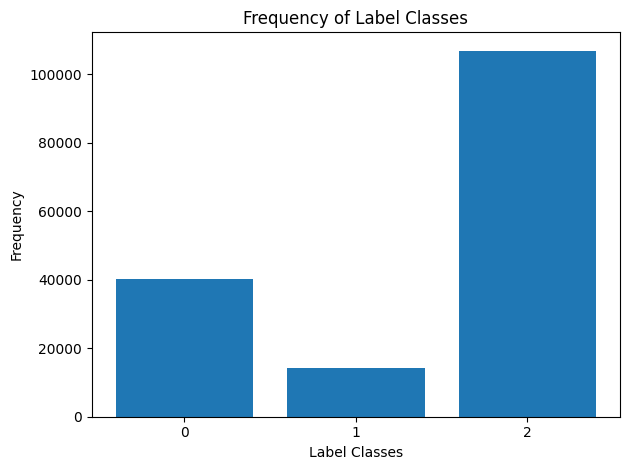

In [24]:
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Label Classes')
plt.ylabel('Frequency')
plt.title('Frequency of Label Classes')
plt.xticks(ticks=class_counts.index)
plt.tight_layout()
plt.show()

### Removing not useful rows

In [ ]:
df[df['condition'] == '5</span> users found this comment helpful.'].head(3)

,drugName,condition,review,rating,usefulCount,label,label_name
11446,Gianvi,5</span> users found this comment helpful.,"""I am 18 years old. When I was put on this med...",1,5,0,Negative
12449,Klonopin,5</span> users found this comment helpful.,"""I tried this for my RSD/CRPS and it helped lo...",9,5,2,Positive
15791,Hydromet,5</span> users found this comment helpful.,"""Amazing for pain and cough alike""",9,5,2,Positive


In [ ]:
list_idx = set(df.index)
span_list = []
for i, row in df.iterrows():
  if isinstance(row['condition'], str) and '</span>' in row['condition']:
    span_list.append(i)

#len(span_list) #900
new_idx = list_idx.difference(set(span_list))
df_clean = df.iloc[list(new_idx)].reset_index(drop=True)

In [ ]:
df_clean[df_clean['condition'] == '5</span> users found this comment helpful.'].head(3)

,drugName,condition,review,rating,usefulCount,label,label_name


In [ ]:
df_clean.info()
#df.shape #(161297, 7)
#df_clean.shape #(160397, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160397 entries, 0 to 160396
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   drugName     160397 non-null  object
 1   condition    159498 non-null  object
 2   review       160397 non-null  object
 3   rating       160397 non-null  int64 
 4   usefulCount  160397 non-null  int64 
 5   label        160397 non-null  int64 
 6   label_name   160397 non-null  object
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


### Cleaning the 'review' column and removing null valued rows

In [ ]:
has_null_values = df_clean['condition'].isnull().any()
print(has_null_values)

True


In [ ]:
df_clean.tail()

,drugName,condition,review,rating,usefulCount,label,label_name
160392,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,125,2,Positive
160393,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,34,0,Negative
160394,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,35,0,Negative
160395,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,79,2,Positive
160396,Lubiprostone,"Constipation, Chronic","""I&#039;ve had chronic constipation all my adu...",9,116,2,Positive


In [ ]:
df_clean['review'] = df_clean['review'].str.lower()
df_clean['review'] = df_clean['review'].str.replace("&#039;", "") #removal of repeated &#039; occurences
df_clean['review'] = df_clean['review'].str.replace(r'^\s+|\s+?$','') #for leading and trailing whitespaces
df_clean['review'] = df_clean['review'].str.replace(r'\s+',' ') #multiple spaces remove
df_clean['review'] = df_clean['review'].str.replace(r'\.{2,}', ' ') #multiple dots remove like ....
df_clean = df_clean.dropna(subset=['condition']) #some condition values are null
#df_clean.shape #(159498, 7)

In [ ]:
df_clean.tail()

,drugName,condition,review,rating,usefulCount,label,label_name
160392,Campral,Alcohol Dependence,"""i wrote my first report in mid-october of 201...",10,125,2,Positive
160393,Metoclopramide,Nausea/Vomiting,"""i was given this in iv before surgey. i immed...",1,34,0,Negative
160394,Orencia,Rheumatoid Arthritis,"""limited improvement after 4 months, developed...",2,35,0,Negative
160395,Thyroid desiccated,Underactive Thyroid,"""ive been on thyroid medication 49 years, i sp...",10,79,2,Positive
160396,Lubiprostone,"Constipation, Chronic","""ive had chronic constipation all my adult lif...",9,116,2,Positive


In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159498 entries, 0 to 160396
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   drugName     159498 non-null  object
 1   condition    159498 non-null  object
 2   review       159498 non-null  object
 3   rating       159498 non-null  int64 
 4   usefulCount  159498 non-null  int64 
 5   label        159498 non-null  int64 
 6   label_name   159498 non-null  object
dtypes: int64(3), object(4)
memory usage: 13.8+ MB


In [ ]:
#df['review'][11]

'"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects."'

In [ ]:
#df_clean['review'][11]

'"i have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them. i only take cymbalta now mostly for pain. when i began deplin, i noticed a major improvement overnight. more energy, better disposition, and no sinking to the low lows of major depression. i have been taking it for about 3 months now and feel like a normal person for the first time ever. best thing, no side effects."'

### Save df and load df

In [ ]:
torch.cuda.is_available()

True

In [ ]:
#Save df
#df_clean.to_parquet('/content/drive/MyDrive/Colab Notebooks/Data Analytics Project/df_clean_save/df.parquet')

In [ ]:
#Load df
df_load = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Data Analytics Project/df_clean_save/df.parquet')

In [ ]:
df_load.info() #159498 | memory usage: 9.7+ MB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159498 entries, 0 to 160396
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   drugName         159498 non-null  object
 1   condition        159498 non-null  object
 2   review           159498 non-null  object
 3   rating           159498 non-null  int64 
 4   usefulCount      159498 non-null  int64 
 5   label            159498 non-null  int64 
 6   label_name       159498 non-null  object
 7   scispacy_review  2976 non-null    object
dtypes: int64(3), object(5)
memory usage: 15.0+ MB


### Applying BERT tokenizer

In [4]:
tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")

def filter_records(df, tokenizer, review_column, max_tokens=512):
    selected_records = []
    review_column

    for index, row in df.iterrows():
        text = row[review_column]
        tokens = tokenizer.tokenize(text)
        row['bert_token_len'] = len(tokens)

        if len(tokens) <= max_tokens:
            selected_records.append(row)

    selected_df = pd.DataFrame(selected_records)
    return selected_df

In [72]:
text = "It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil depakene"
tokens = tokenizer_bert.encode(text, return_tensors='pt')
print("These are the tokens", tokens)
for token in tokens[0]:
  t = tokenizer_bert.decode([token])
  print(token, tokenizer_bert.decode([token]))

These are the tokens tensor([[  101,  2009,  2038,  2053,  2217,  3466,  1010,  1045,  2202,  2009,
          1999,  5257,  1997,  2011, 16033, 10415,  1019, 11460,  1998,  3869,
          3514,  2139,  4502,  7520,  2063,   102]])
tensor(101) [CLS]
tensor(2009) it
tensor(2038) has
tensor(2053) no
tensor(2217) side
tensor(3466) effect
tensor(1010) ,
tensor(1045) i
tensor(2202) take
tensor(2009) it
tensor(1999) in
tensor(5257) combination
tensor(1997) of
tensor(2011) by
tensor(16033) ##sto
tensor(10415) ##lic
tensor(1019) 5
tensor(11460) mg
tensor(1998) and
tensor(3869) fish
tensor(3514) oil
tensor(2139) de
tensor(4502) ##pa
tensor(7520) ##ken
tensor(2063) ##e
tensor(102) [SEP]


In [ ]:
df_filter = filter_records(df_load, tokenizer_bert, 'review')
#df_filter["bert_token_len2"] = df_filter["review"].apply(lambda x: len(tokenizer(x, add_special_tokens=False)["input_ids"]))
df_filter

In [ ]:
df_filter.info() #159448 | memory usage: 12.2+ MB | 9 columns

In [ ]:
#len(df_filter[df_filter['bert_token_len'] == df_filter['bert_token_len2']]) #159448
#df_filter = df_filter.drop(columns=["bert_token_len2"])

159448

In [ ]:
#Save df
df_filter.to_parquet('/content/drive/MyDrive/Colab Notebooks/Data Analytics Project/df_clean_save/df_filter.parquet')

### Balancing dataset

In [ ]:
positive = df_filter[df_filter['label'] == 2]
neutral = df_filter[df_filter['label'] == 1]
negative = df_filter[df_filter['label'] == 0]

num_to_keep = int(max(len(neutral), len(negative)))

undersampled_positive = resample(positive, n_samples=num_to_keep, replace=False, random_state=100)
oversampled_nuetral = resample(neutral, replace=True, n_samples=num_to_keep, random_state=100)

df_balance = pd.concat([undersampled_positive, oversampled_nuetral, negative])
df_b = df_balance.sample(frac=1, random_state=100).reset_index(drop=True)


In [ ]:
positive.head()

,drugName,condition,review,rating,usefulCount,label,label_name,scispacy_review,bert_token_len
0,Valsartan,Left Ventricular Dysfunction,"""it has no side effect, i take it in combinati...",9,27,2,Positive,"""it has no side effect, i take it in combinati...",22
1,Guanfacine,ADHD,"""my son is halfway through his fourth week of ...",8,192,2,Positive,"""my son is halfway through his fourth week of ...",169
3,Ortho Evra,Birth Control,"""this is my first time using any form of birth...",8,10,2,Positive,"""this is my first time using any form of birth...",108
4,Buprenorphine / naloxone,Opiate Dependence,"""suboxone has completely turned my life around...",9,37,2,Positive,"""suboxone has completely turned my life around...",170
7,Aripiprazole,Bipolar Disorde,"""abilify changed my life. there is hope. i was...",10,32,2,Positive,"""abilify changed my life. there is hope. i was...",183


In [ ]:
print(positive.shape)
print(neutral.shape)
print(negative.shape)

(105720, 9)
(14160, 9)
(39568, 9)


In [ ]:
df_b.info() #118704 | memory usage: 8.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118704 entries, 0 to 118703
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   drugName         118704 non-null  object
 1   condition        118704 non-null  object
 2   review           118704 non-null  object
 3   rating           118704 non-null  int64 
 4   usefulCount      118704 non-null  int64 
 5   label            118704 non-null  int64 
 6   label_name       118704 non-null  object
 7   scispacy_review  2182 non-null    object
 8   bert_token_len   118704 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 8.2+ MB


In [ ]:
positive_b = df_b[df_b['label'] == 2]
neutral_b = df_b[df_b['label'] == 1]
negative_b = df_b[df_b['label'] == 0]

In [ ]:
print(positive_b.shape)
print(neutral_b.shape)
print(negative_b.shape) #(39568, 9) each

(39568, 9)
(39568, 9)
(39568, 9)


### Save balanced df and load df

In [ ]:
#Save df
df_b.to_parquet('/content/drive/MyDrive/Colab Notebooks/Data Analytics Project/df_clean_save/df_balanced.parquet')

In [ ]:
#Load df
df_b_load=pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Data Analytics Project/df_clean_save/df_balanced.parquet')

In [ ]:
df_b_load.info() #118704 | memory usage: 8.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118704 entries, 0 to 118703
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   drugName         118704 non-null  object
 1   condition        118704 non-null  object
 2   review           118704 non-null  object
 3   rating           118704 non-null  int64 
 4   usefulCount      118704 non-null  int64 
 5   label            118704 non-null  int64 
 6   label_name       118704 non-null  object
 7   scispacy_review  2182 non-null    object
 8   bert_token_len   118704 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 8.2+ MB


### Applying Scispacy

In [ ]:
import spacy

nlp_bcdr = spacy.load("en_ner_bc5cdr_md")
gpu = spacy.prefer_gpu()
print(gpu)

True


In [ ]:
nlp_sci = spacy.load("en_core_sci_scibert")

In [ ]:
def scispacy_process(review_text):
  doc = nlp_bcdr(review_text)
  #processed_text = " ".join([token.lemma_ for token in doc])
  ner = [f"({ent},{ent.label_})" for ent in doc.ents]
  ner = set(ner)
  if ner:
    review_ner = review_text + str(ner)
    return review_ner
  else:
    return review_text

In [ ]:
df_b_load['scispacy_review'] = df_b_load['review'].apply(scispacy_process)

In [ ]:
df_b_load['scispacy_review'][111900]

'"it does very well for pain; i have fibromyalgia and it works for me. it allows me to be able to keep up my 4 active boys; ages 15, 10, 7 and 2. the only reason i dont give it a 10 is that is works quick, but it completely kills my appetite. i otherwise love this medicine."{\'(fibromyalgia,DISEASE)\', \'(pain,DISEASE)\'}'

In [ ]:
df_b_load.head()

,drugName,condition,review,rating,usefulCount,label,label_name,scispacy_review,bert_token_len
0,Zubsolv,Opiate Dependence,"""ok my wife has been on this zobsolv for over ...",1,8,0,Negative,"""ok my wife has been on this zobsolv for over ...",148
1,Pristiq,ibromyalgia,"""ive been using pristiq for two and half month...",9,11,2,Positive,"""ive been using pristiq for two and half month...",50
2,Sertraline,Depression,"""my experience with sertraline has been an int...",10,39,2,Positive,"""my experience with sertraline has been an int...",154
3,Morphine,Pain,"""in 2004 i was diagnosed with adult onset stil...",10,10,2,Positive,"""in 2004 i was diagnosed with adult onset stil...",133
4,Phenazopyridine,Interstitial Cystitis,"""this did nothing for the cramping and pain. i...",2,16,0,Negative,"""this did nothing for the cramping and pain. i...",50


In [ ]:
df_b_load.info() #118704 | memory usage: 8.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118704 entries, 0 to 118703
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   drugName         118704 non-null  object
 1   condition        118704 non-null  object
 2   review           118704 non-null  object
 3   rating           118704 non-null  int64 
 4   usefulCount      118704 non-null  int64 
 5   label            118704 non-null  int64 
 6   label_name       118704 non-null  object
 7   scispacy_review  118704 non-null  object
 8   bert_token_len   118704 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 8.2+ MB


### Save and Load Balanced + Sciscpacy df

In [ ]:
#Save df
df_b_load.to_parquet('/content/drive/MyDrive/Colab Notebooks/Data Analytics Project/df_clean_save/df_bal_scispacy.parquet')

In [ ]:
#Load df
df_bal_sci_load=pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Data Analytics Project/df_clean_save/df_bal_scispacy.parquet')

In [ ]:
df_bal_sci_load.info() #118704 | memory usage: 8.2+ MB | 9 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118704 entries, 0 to 118703
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   drugName         118704 non-null  object
 1   condition        118704 non-null  object
 2   review           118704 non-null  object
 3   rating           118704 non-null  int64 
 4   usefulCount      118704 non-null  int64 
 5   label            118704 non-null  int64 
 6   label_name       118704 non-null  object
 7   scispacy_review  118704 non-null  object
 8   bert_token_len   118704 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 8.2+ MB


In [ ]:
#df_bal_sci_load = df_bal_sci_load.drop(columns=["review","usefulCount"])
df_bal_sci_load.info() #118704 | memory usage: 6.3+ MB | 7 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118704 entries, 0 to 118703
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   drugName         118704 non-null  object
 1   condition        118704 non-null  object
 2   rating           118704 non-null  int64 
 3   label            118704 non-null  int64 
 4   label_name       118704 non-null  object
 5   scispacy_review  118704 non-null  object
 6   bert_token_len   118704 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 6.3+ MB


### Applying BERT Tokenizer on SciSpac-ied df

In [ ]:
df_bal_sci_filter = filter_records(df_bal_sci_load, tokenizer_bert, 'scispacy_review')

In [ ]:
df_bal_sci_filter.head()

,drugName,condition,rating,label,label_name,scispacy_review,bert_token_len
0,Zubsolv,Opiate Dependence,1,0,Negative,"""ok my wife has been on this zobsolv for over ...",181
1,Pristiq,ibromyalgia,9,2,Positive,"""ive been using pristiq for two and half month...",78
2,Sertraline,Depression,10,2,Positive,"""my experience with sertraline has been an int...",181
3,Morphine,Pain,10,2,Positive,"""in 2004 i was diagnosed with adult onset stil...",163
4,Phenazopyridine,Interstitial Cystitis,2,0,Negative,"""this did nothing for the cramping and pain. i...",88


In [ ]:
df_bal_sci_filter.info() #118699 | memory usage: 7.2+ MB | 7 columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118699 entries, 0 to 118703
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   drugName         118699 non-null  object
 1   condition        118699 non-null  object
 2   rating           118699 non-null  int64 
 3   label            118699 non-null  int64 
 4   label_name       118699 non-null  object
 5   scispacy_review  118699 non-null  object
 6   bert_token_len   118699 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 7.2+ MB


### Save and Load Balanced + Sciscpacy + Tokenize Filtered df

In [ ]:
#Save df
df_bal_sci_filter.to_parquet('/content/drive/MyDrive/Colab Notebooks/Data Analytics Project/df_clean_save/df_bal_scispacy_filter.parquet')

In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/Data Analytics Project/'

In [25]:
#Load df
df=pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Data Analytics Project/df_clean_save/df_bal_scispacy_filter.parquet')

In [27]:
df.info() #118699 | memory usage: 7.2+ MB | 7 columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118699 entries, 0 to 118703
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   drugName         118699 non-null  object
 1   condition        118699 non-null  object
 2   rating           118699 non-null  int64 
 3   label            118699 non-null  int64 
 4   label_name       118699 non-null  object
 5   scispacy_review  118699 non-null  object
 6   bert_token_len   118699 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 7.2+ MB


In [28]:
df = df.rename(columns = {'scispacy_review':'review'})

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118699 entries, 0 to 118703
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   drugName        118699 non-null  object
 1   condition       118699 non-null  object
 2   rating          118699 non-null  int64 
 3   label           118699 non-null  int64 
 4   label_name      118699 non-null  object
 5   review          118699 non-null  object
 6   bert_token_len  118699 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 7.2+ MB


### Token/Seq length

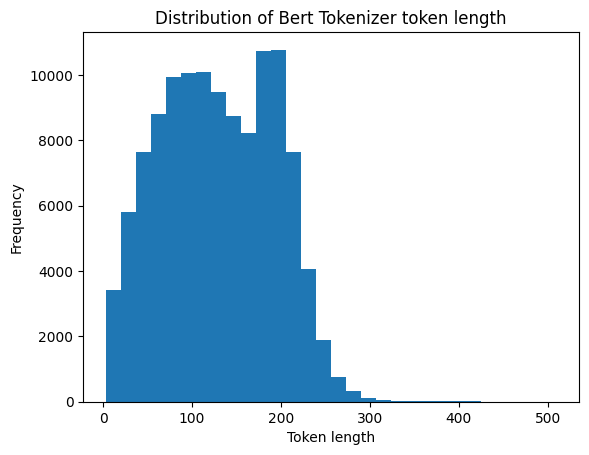

In [ ]:
plt.hist(df['bert_token_len'], bins=30)
plt.xlabel('Token length')
plt.ylabel('Frequency')
plt.title('Distribution of Bert Tokenizer token length')
plt.show()

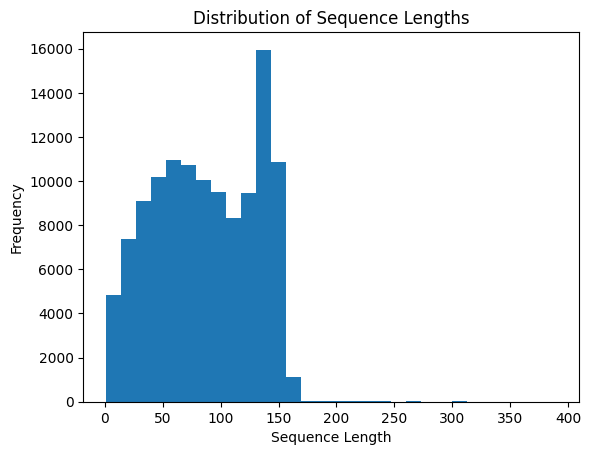

In [ ]:
# get length of all the reviews
seq_len = [len(i.split()) for i in df.review.values] # //df['review']

pd.Series(seq_len).hist(bins = 30)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.grid(False)
plt.show()

In [30]:
class_counts_2 = df['label'].value_counts()

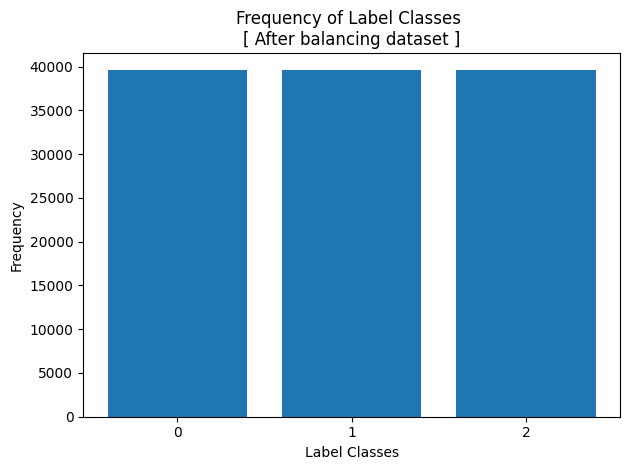

In [36]:
plt.bar(class_counts_2.index, class_counts_2.values)
plt.xlabel('Label Classes')
plt.ylabel('Frequency')
plt.title('Frequency of Label Classes \n[ After balancing dataset ]')
plt.xticks(ticks=class_counts_2.index)
plt.tight_layout()
plt.show()

### Extra Config

In [ ]:
#Following B. Biseda and K. Mo, “Enhancing pharmacovigilance with drug reviews and
#social media,” arXiv preprint arXiv:2004.08731, 2020. 6, 8, 15
'''
class Config():
    epochs = 10
    batch_size = 32
    max_length = 128 #250
    lr = 2e-5
    hidden_size = 128
    epsilon = 1e-8
    random_state=100
    add_special_tokens=True
    return_attention_mask=True
    padding='max_length'
    truncation=True
    return_token_type_ids=False
    return_tensors='pt'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config = Config()
'''

In [ ]:
#Following C. Col´on-Ruiz and I. Segura-Bedmar, “Comparing deep learning architectures for sentiment analysis on drug reviews,” Journal of
#Biomedical Informatics, vol. 110, p. 103539, 2020. [Online]. Available:
#https://www.sciencedirect.com/science/article/pii/S1532046420301672

class Config():
    epochs = 20
    batch_size = 200
    max_length = 250 #512
    lr = 0.001
    hidden_size = 128
    epsilon = 1e-8
    random_state=100
    add_special_tokens=True
    return_attention_mask=True
    padding='max_length'
    truncation=True
    return_token_type_ids=False
    return_tensors='pt'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config = Config()

## Best results with this config

### Config

In [ ]:
#Following A. Shiju and Z. He, “Classifying drug ratings using user reviews with
#transformer-based language models,” in 2022 IEEE 10th International Conference
#on Healthcare Informatics (ICHI), 2022, pp. 163–169. 7, 8, 15

class Config():
    epochs = 10
    batch_size = 6
    max_length = 512
    lr = 5e-5
    hidden_size = 128
    epsilon = 1e-8
    random_state=100
    add_special_tokens=True
    return_attention_mask=True
    padding='max_length'
    truncation=True
    return_token_type_ids=False
    return_tensors='pt'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config = Config()


In [ ]:
params = {
    "epochs":config.epochs,
    "batch_size":config.batch_size,
    "max_length":config.max_length,
    "lr":config.lr,
    "hidden_size":config.hidden_size,
    "eps":config.epsilon,
    "random_state":config.random_state,
    "add_special_tokens":config.add_special_tokens,
    "return_attention_mask":config.return_attention_mask,
    "padding":config.padding,
    "truncation":config.truncation,
    "return_token_type_ids":config.return_token_type_ids,
    "return_tensors":config.return_tensors,
    "device":str(config.device),
         }

In [ ]:
device = config.device
device

device(type='cuda', index=0)

In [ ]:
torch.cuda.is_available()

True

### Train Test split

In [ ]:
train_df, temp_df = train_test_split(df,test_size=0.3,random_state=100)

val_df, test_df = train_test_split(temp_df,test_size=0.5,random_state=100)
#70:15:15

In [ ]:
print(len(train_df['label'].unique()))
print("TrainDF:",train_df.shape)
print(len(val_df['label'].unique()))
print("Valdf:",val_df.shape)
print(len(test_df['label'].unique()))
print("Testdf:",test_df.shape)

3
TrainDF: (83089, 7)
3
Valdf: (17805, 7)
3
Testdf: (17805, 7)


In [ ]:
train_df.info() #83089 | memory usage: 5.1+ MB | 7 columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83089 entries, 32168 to 38409
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   drugName        83089 non-null  object
 1   condition       83089 non-null  object
 2   rating          83089 non-null  int64 
 3   label           83089 non-null  int64 
 4   label_name      83089 non-null  object
 5   review          83089 non-null  object
 6   bert_token_len  83089 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 5.1+ MB


### BERT

In [ ]:
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')

model_bert = BertModel.from_pretrained('bert-base-uncased')
#model = model.to(device)

#### Batch Encode into input id, attention mask

In [ ]:
train_encoded = tokenizer_bert.batch_encode_plus(train_df.review.values,
                                                 add_special_tokens=config.add_special_tokens,
                                                 return_attention_mask=config.return_attention_mask,
                                                 padding=config.padding,
                                                 max_length=config.max_length,
                                                 truncation = config.truncation,
                                                 return_token_type_ids = config.return_token_type_ids,
                                                 return_tensors=config.return_tensors)

In [ ]:
val_encoded = tokenizer_bert.batch_encode_plus(val_df.review.values,
                                               add_special_tokens=config.add_special_tokens,
                                               return_attention_mask=config.return_attention_mask,
                                               padding=config.padding,
                                               max_length=config.max_length,
                                               truncation = config.truncation,
                                               return_token_type_ids = config.return_token_type_ids,
                                               return_tensors=config.return_tensors)

In [ ]:
test_encoded = tokenizer_bert.batch_encode_plus(test_df.review.values,
                                               add_special_tokens=config.add_special_tokens,
                                               return_attention_mask=config.return_attention_mask,
                                               padding=config.padding,
                                               max_length=config.max_length,
                                               truncation = config.truncation,
                                               return_token_type_ids = config.return_token_type_ids,
                                               return_tensors=config.return_tensors)

#### Integer input & mask to Tensor

In [ ]:
train_input = torch.tensor(train_encoded['input_ids'])
train_att_mask = torch.tensor(train_encoded['attention_mask'])
train_labels = torch.tensor(train_df.label.values)

val_input = torch.tensor(val_encoded['input_ids'])
val_att_mask = torch.tensor(val_encoded['attention_mask'])
val_labels = torch.tensor(val_df.label.values)

test_input = torch.tensor(test_encoded['input_ids'])
test_att_mask = torch.tensor(test_encoded['attention_mask'])
test_labels = torch.tensor(test_df.label.values)

<ipython-input-24-5b51f894ed33>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_input = torch.tensor(train_encoded['input_ids'])
<ipython-input-24-5b51f894ed33>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_att_mask = torch.tensor(train_encoded['attention_mask'])
<ipython-input-24-5b51f894ed33>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_input = torch.tensor(val_encoded['input_ids'])
<ipython-input-24-5b51f894ed33>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

#### Creating Tensor data & DataLoaders

In [ ]:
train_dataset = TensorDataset(train_input, train_att_mask, train_labels)
val_dataset = TensorDataset(val_input, val_att_mask, val_labels)
test_dataset = TensorDataset(test_input, test_att_mask, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size,sampler=RandomSampler(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, sampler=SequentialSampler(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, sampler=SequentialSampler(test_dataset))

### Custom Model

In [ ]:
class BERTBiGRUClassifier(nn.Module):
  def __init__(self, bert_model, tokenizer, hidden_size, num_classes, freeze_bert=True):
    super(BERTBiGRUClassifier, self).__init__()
    self.bert = bert_model
    self.tokenizer = tokenizer
    self.hidden_size = hidden_size
    if freeze_bert:
      for param in self.bert.parameters():
        param.requires_grad = False

    self.bigru = nn.GRU(input_size=self.bert.config.hidden_size,hidden_size=hidden_size, #self.bert.config.hidden_size = 768
                        batch_first=True, bidirectional=True)
    self.dropout = nn.Dropout(0.3)
    #self.fc0 = nn.Linear(768, 512)
    self.fc = nn.Linear(hidden_size * 2, num_classes)
    #self.relu =  nn.ReLU()

  def forward(self, input_ids, attention_mask):
    bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
    #https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel - last_hidden_state = (batch_size, sequence_length, hidden_size)
    #print(type(cls_hs))
    #print(cls_hs.shape)
    #x = self.fc0(cls_hs)
    #x = self.relu(x)
    bert_output = self.dropout(bert_output)
    bigru_output, _ = self.bigru(bert_output) #https://pytorch.org/docs/stable/generated/torch.nn.GRU.html for input and output tensor details
    bigru_output = self.dropout(bigru_output)
    output = self.fc(bigru_output[:, -1, :])

    return output

In [ ]:
model = BERTBiGRUClassifier(model_bert, tokenizer_bert, hidden_size=config.hidden_size, num_classes=3, freeze_bert=True)
model = model.to(device)

In [ ]:
#model.__dict__
model

BERTBiGRUClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

### Optimizer & eval & loss functions

In [ ]:
optimizer = AdamW(model.parameters(), lr=config.lr, eps=config.epsilon)


scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                            num_training_steps=len(train_dataloader)*config.epochs)
#https://www.programcreek.com/python/example/112000/transformers.get_linear_schedule_with_warmup

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
cross_entropy  = nn.CrossEntropyLoss()

In [ ]:
def f1_score_func(preds, labels):
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, label_dict):
  label_dict_inverse = {v: k for k, v in label_dict.items()}

  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  for label in np.unique(labels_flat):
    y_preds = preds_flat[labels_flat==label]
    y_true = labels_flat[labels_flat==label]
    print(f'Class: {label_dict_inverse[label]}')
    print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
def evaluate(validation_dataloader):
  model.eval()

  loss_val_total = 0
  predictions, true_vals = [], []

  for batch in validation_dataloader:
    batch = tuple(b.to(config.device) for b in batch)
    input, att_mask, labels = batch

    with torch.no_grad():
      outputs = model(input, att_mask)

      loss = cross_entropy(outputs, labels)
      loss_val_total = loss_val_total + loss.item()

      outputs = outputs.detach().cpu().numpy()
      predictions.append(outputs)
      true_vals.append(labels.cpu().numpy())

  loss_val_avg = loss_val_total/len(validation_dataloader)
  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)

  return loss_val_avg, predictions, true_vals

In [ ]:
def model_train(model, train_dataloader, val_dataloader):
  for epoch in tqdm(range(1, config.epochs+1)):

    model.train()
    loss_train_total = 0
    #predictions, true_vals = [], []

    #tqdm to show progress of the training
    progress_bar = tqdm(train_dataloader, desc='Epoch {:1d}'.format(epoch), leave=True)

    for batch in progress_bar:
      model.zero_grad()

      batch = tuple(b.to(config.device) for b in batch)
      input, att_mask, labels = batch

      outputs = model(input, att_mask)

      loss = cross_entropy(outputs, labels)
      loss_train_total = loss_train_total + loss.item()
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      optimizer.step()
      scheduler.step()

    torch.save(model.state_dict(), f'ModelBert_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}:')

    loss_train_avg = loss_train_total/len(train_dataloader)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_avg_loss, predictions, true_vals = evaluate(val_dataloader)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_avg_loss}')
    tqdm.write(f'F1 Score: {val_f1}')

### Model create and train

In [ ]:
train_loss = model_train(model, train_dataloader, val_dataloader)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch 1:
Training loss: 0.8769734132175262
Validation loss: 0.7424050470193228
F1 Score: 0.6705506112461475


Epoch 2:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch 2:
Training loss: 0.7204653862863779
Validation loss: 0.6852307485209571
F1 Score: 0.6978383174671106


Epoch 3:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch 3:
Training loss: 0.673278411420492
Validation loss: 0.6269126617246203
F1 Score: 0.7328714343877161


Epoch 4:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch 4:
Training loss: 0.639992804481433
Validation loss: 0.5997675014866723
F1 Score: 0.7452862291680514


Epoch 5:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch 5:
Training loss: 0.6144327004081928
Validation loss: 0.5815546390083101
F1 Score: 0.7568089238665917


Epoch 6:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch 6:
Training loss: 0.5894876348141295
Validation loss: 0.5687594365742471
F1 Score: 0.7662915005343729


Epoch 7:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch 7:
Training loss: 0.5648870158653992
Validation loss: 0.5538768079545763
F1 Score: 0.7769986448558954


Epoch 8:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch 8:
Training loss: 0.5470353245305327
Validation loss: 0.5307982080512577
F1 Score: 0.7904487841198241


Epoch 9:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch 9:
Training loss: 0.5295562456147029
Validation loss: 0.5278921624024709
F1 Score: 0.791896499546516


Epoch 10:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch 10:
Training loss: 0.5119207104524741
Validation loss: 0.507604099644555
F1 Score: 0.8063485667107552


Epoch 11:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch 11:
Training loss: 0.49542256050671524
Validation loss: 0.4973218543661965
F1 Score: 0.8099950307548792


Epoch 12:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch 12:
Training loss: 0.4792250194228612
Validation loss: 0.4929472542471356
F1 Score: 0.8140210513917259


Epoch 13:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch 13:
Training loss: 0.46909980991711986
Validation loss: 0.48273220989439225
F1 Score: 0.8191279681962207


Epoch 14:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch 14:
Training loss: 0.4535725600301073
Validation loss: 0.4895348956187566
F1 Score: 0.8174478501945169


Epoch 15:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch 15:
Training loss: 0.448920024272341
Validation loss: 0.48156798084576924
F1 Score: 0.8197565396006518


Epoch 16:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch 16:
Training loss: 0.4381969137690388
Validation loss: 0.4654996934864256
F1 Score: 0.8273438771042938


Epoch 17:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch 17:
Training loss: 0.4309977492174277
Validation loss: 0.4728675087292989
F1 Score: 0.8260462045558333


Epoch 18:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch 18:
Training loss: 0.4255940089575373
Validation loss: 0.4520098994175593
F1 Score: 0.8346707925854185


Epoch 19:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch 19:
Training loss: 0.41522563349169034
Validation loss: 0.4574136295252376
F1 Score: 0.8346076391505103


Epoch 20:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch 20:
Training loss: 0.4115330036729574
Validation loss: 0.4563207189242045
F1 Score: 0.8349308128465973


In [ ]:
import pickle

In [ ]:
pickle.dump(model, open('/content/drive/MyDrive/Colab Notebooks/Data Analytics Project/Pickle_files/model_bert_colon.pickle', 'wb'))

### Testset

In [ ]:
model.load_state_dict(torch.load('/content/ModelBert_epoch_18.model'))

<All keys matched successfully>

In [ ]:
_, predictions, true = evaluate(val_dataloader)

In [ ]:
preds = np.argmax(predictions, axis=1).flatten()
print(classification_report(preds, true))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83      5237
           1       0.89      0.74      0.81      7170
           2       0.83      0.92      0.87      5398

    accuracy                           0.83     17805
   macro avg       0.83      0.84      0.83     17805
weighted avg       0.84      0.83      0.83     17805



In [ ]:
_, predictions, true = evaluate(test_dataloader)

In [ ]:
preds = np.argmax(predictions, axis=1).flatten()
print(classification_report(preds, true))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83      5257
           1       0.90      0.75      0.82      7204
           2       0.84      0.92      0.88      5344

    accuracy                           0.84     17805
   macro avg       0.84      0.85      0.84     17805
weighted avg       0.85      0.84      0.84     17805



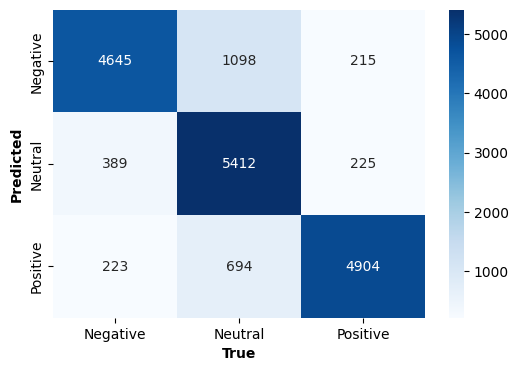

"\nplt.figure(figsize=(6, 4))\nax = sns.heatmap(bert_res, annot=True, cmap='Blues', fmt='d', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])\nax.set_xlabel(r'\textbf{Predicted}')\nax.set_ylabel(r'\textbf{True}')\nplt.title('Confusion Matrix')\nplt.show()\n"

In [ ]:
bert_res = confusion_matrix(true, preds)

plt.figure(figsize=(6, 4))
ax=sns.heatmap(bert_res, annot=True, cmap='Blues', fmt='d',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('True', fontweight='bold')
plt.ylabel('Predicted', fontweight='bold')
plt.show()

In [ ]:
import gc
gc.collect()

98

In [ ]:
torch.cuda.empty_cache()

### Bio Clinical BERT

In [ ]:
#Just to check
model_bcb = "emilyalsentzer/Bio_ClinicalBERT"
config2 = AutoConfig.from_pretrained(model_bcb)

hidden_size = config2.hidden_size
hidden_size
#768

768

### References:
1. https://github.com/rohan-paul/MachineLearning-DeepLearning-Code-for-my-YouTube-Channel/blob/master/NLP/Add-task_specific_custom_layer_to_model.ipynb
2. https://www.youtube.com/watch?v=mw7ay38--ak